In [2]:
!pip install pyod

  Created wheel for pyod: filename=pyod-0.9.7-py3-none-any.whl size=136277 sha256=26737a6c69a868abdee1893783aa1a3f00f9232006c43d2c5e4a19a0cb2d649d
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\fa\45\81\0fc4ece11f8964a5d6775b37517f1955df8a832b4540dfb08a
Successfully built pyod


In [6]:
from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize


On Training Data:
KNN ROC:0.9992, precision @ rank n:0.95

On Test Data:
KNN ROC:1.0, precision @ rank n:1.0


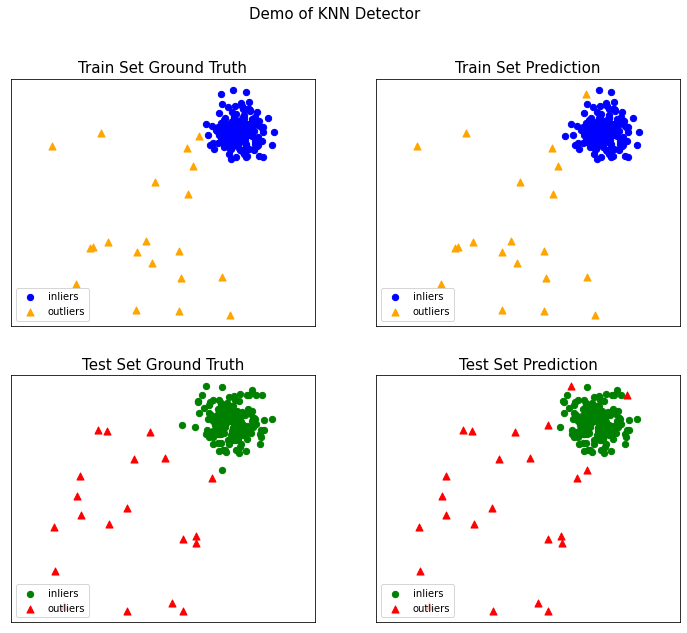

In [13]:
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=2,
                  contamination=contamination,
                  random_state=42)

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=True)

In [22]:
!pip install combo

  Created wheel for combo: filename=combo-0.1.2-py3-none-any.whl size=42025 sha256=90d9771df2167ae67e607cdc1f2bfc7ca3bf0ec0ff993a19ba9367e51806c627
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\dd\2f\8c\2156b14ed7064d80a2b9de8aeaeeafa3c0997762cf149c52ed
Successfully built combo


In [23]:
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization, median
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

In [16]:
# Define data file and read X and y
# Generate some data if the source data is missing
mat_file = 'cardio.mat'
try:
    mat = loadmat(mat_file)

except TypeError:
    print('{data_file} does not exist. Use generated data'.format(
        data_file=mat_file))
    X, y = generate_data(train_only=True)  # load data
except IOError:
    print('{data_file} does not exist. Use generated data'.format(
        data_file=mat_file))
    X, y = generate_data(train_only=True)  # load data
else:
    X = mat['X']
    y = mat['y'].ravel()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [26]:
import numpy as np

In [ ]:
# standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

n_clf = 20  # number of base detectors

# Initialize 20 base detectors for combination
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
          150, 160, 170, 180, 190, 200]

train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

print('Combining {n_clf} kNN detectors'.format(n_clf=n_clf))

for i in range(n_clf):
    k = k_list[i]

    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm)

In [29]:
train_scores.shape

(1098, 20)

In [27]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,
                                                   test_scores)
# Combination by average
y_by_average = average(test_scores_norm)
evaluate_print('Combination by Average', y_test, y_by_average)

# Combination by max
y_by_maximization = maximization(test_scores_norm)
evaluate_print('Combination by Maximization', y_test, y_by_maximization)

# Combination by median
y_by_median = median(test_scores_norm)
evaluate_print('Combination by Median', y_test, y_by_median)

# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
evaluate_print('Combination by AOM', y_test, y_by_aom)

# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)
evaluate_print('Combination by MOA', y_test, y_by_moa)

Combining 20 kNN detectors
Combination by Average ROC:0.9246, precision @ rank n:0.5541
Combination by Maximization ROC:0.9261, precision @ rank n:0.5811
Combination by Median ROC:0.9309, precision @ rank n:0.5811
Combination by AOM ROC:0.9311, precision @ rank n:0.5946
Combination by MOA ROC:0.9306, precision @ rank n:0.5676


In [ ]:
# -*- coding: utf-8 -*-
"""Compare all detection algorithms by plotting decision boundaries and
the number of decision boundaries.
"""

from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP
from pyod.models.cof import COF
from pyod.models.sod import SOD

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Average KNN
Model 8 Local Outlier Factor (LOF)
Model 9 Minimum Covariance Determinant (MCD)
Model 10 One-class SVM (OCSVM)
Model 11 Principal Component Analysis (PCA)
Model 12 Locally Selective Combination (LSCP)

1 fitting Angle-based Outlier Det

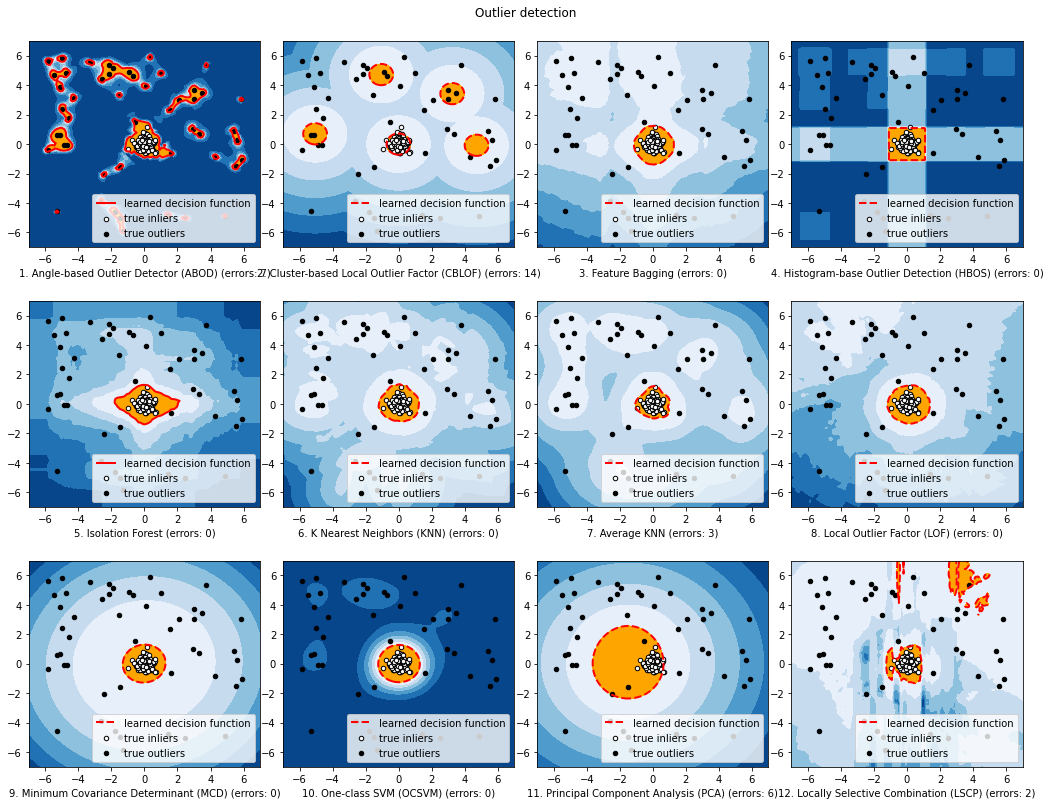

In [30]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print(
    'Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(
        shape=ground_truth.shape))
print(ground_truth, '\n')

random_state = 42
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    # 'Median KNN': KNN(method='median',
    #                   contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    # 'Local Correlation Integral (LOCI)':
    #     LOCI(contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    # 'Stochastic Outlier Selection (SOS)': SOS(
    #     contamination=outliers_fraction),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state),
    # 'Connectivity-Based Outlier Factor (COF)':
    #     COF(n_neighbors=35, contamination=outliers_fraction),
    # 'Subspace Outlier Detection (SOD)':
    #     SOD(contamination=outliers_fraction),
}

# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

# Fit the models with the generated data and
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print()
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.savefig('ALL.png', dpi=300)
plt.show()

## angle based


On Training Data:
ABOD ROC:0.9944, precision @ rank n:0.9

On Test Data:
ABOD ROC:0.9878, precision @ rank n:0.8


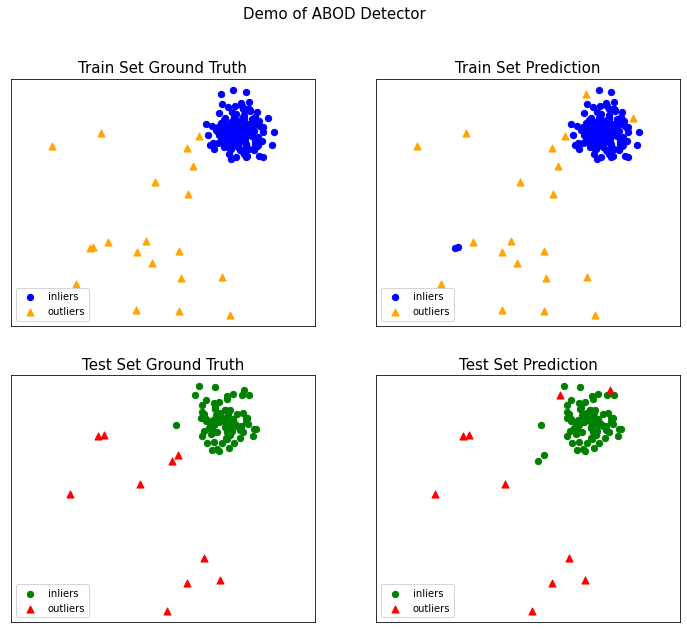

In [31]:
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=2,
                  contamination=contamination,
                  random_state=42)

# train ABOD detector
clf_name = 'ABOD'
clf = ABOD()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)